index start = 5
/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0051.h5 EXISTS, CONTINUE...
/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0052.h5 EXISTS, CONTINUE...
Loading theory file Ne_total.txt
Loading theory file SF6_total.txt
/cds/data/drpsrcf/cxi/cxilx9320/scratch/hdf5/smalldata/cxilx9320_Run0053.h5 EXISTS, CONTINUE...
sf6
[0.84924878 0.54321873 0.3239002  0.18569225 0.11322702 0.0873033
 0.08965755 0.10582509 0.12607843 0.14468324 0.15885842 0.16762565
 0.17097557 0.16942851 0.16389985 0.1555562  0.14572738 0.13573138
 0.12664635 0.11911524 0.11327072 0.10876173 0.10491921 0.10100376
 0.09643969 0.09097934 0.08476387 0.07826675 0.07214238 0.06705342]
Vector q =
[1.25489378 1.45489378 1.65489378 1.85489378 2.05489378 2.25489378
 2.45489378 2.65489378 2.85489378 3.05489378 3.25489378 3.45489378
 3.65489378 3.85489378 4.05489378 4.25489378 4.45489378 4.65489378
 4.85489378 5.05489378 5.25489378 5.45489378 5.65489378 5.85489378
 6.05489378

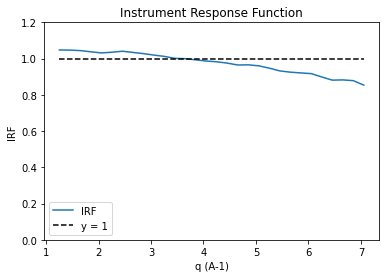

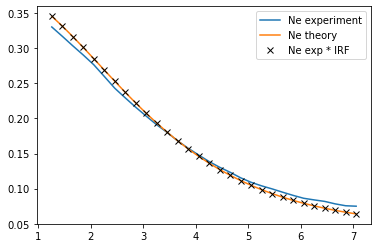

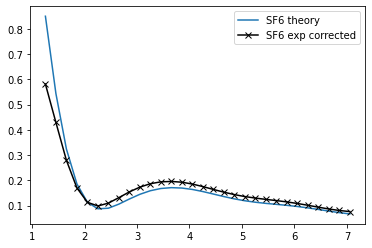

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

# custom imports (from current directory)
# from run_numbers_vars import *  # contains dark, blank, Ne, SF6 run numbers
from thomas_functions import Thomas

indexstart = 5
m = Thomas(indexstart)


print('index start = %d' % indexstart)
# BLANK RUN
q, azav_blank = m.get_azav(m.blank_run_numbers, indexstart)
# END BLANK RUN
###

# Neon and IRF
_, ne_azav          = m.get_azav(m.ne_run_numbers, indexstart)
q_theory, ne_theory = m.load_theory(m.ne_theory_file)
ne_theory_interp    = m.interp_theory(q, q_theory, ne_theory)
irf                 = m.get_irf(azav_blank, q, ne_azav, q_theory, ne_theory)
ne_exp_corrected    = m.irf_blank_correction(ne_azav, azav_blank, irf)

# Plots
plt.figure()
plt.plot(q, irf)
plt.plot(q, np.ones(q.shape),'k--')
plt.ylim([0, 1.2])
plt.title('Instrument Response Function')
plt.xlabel('q (A-1)')
plt.ylabel('IRF')
plt.legend(['IRF', 'y = 1'])

plt.figure()
plt.plot(q, m.normalise(q, ne_azav))
plt.plot(q, m.normalise(q, ne_theory_interp)) 
plt.plot(q, m.normalise(q, ne_exp_corrected), 'kx')
plt.legend(['Ne experiment', 'Ne theory', 'Ne exp * IRF'])

# END Neon and IRF
###

# SF6 check
q_theory, sf6_theory  = m.load_theory(m.sf6_theory_file)
sf6_theory_interp     = m.interp_theory(q, q_theory, sf6_theory)
sf6_theory_normalised = m.normalise(q, sf6_theory_interp)

_, sf6_azav           = m.get_azav(m.sf6_run_numbers, indexstart)
sf6_azav_corrected    = m.irf_blank_correction(sf6_azav, azav_blank, irf)
sf6_exp_normalised    = m.normalise(q, sf6_azav_corrected)

plt.figure()
plt.plot(q, sf6_theory_normalised)
plt.plot(q, sf6_exp_normalised, 'kx-')
plt.legend(['SF6 theory', 'SF6 exp corrected'])
# END SF6 check
###
print('sf6'); print(sf6_theory_normalised)
print('Vector q ='); print(q)
#print('Size of qbin increment: %f (A-1)' % qbin)
#print('qbins:'); print(qbins)
#print(x)
#print(z)